In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal RAG with Gemini, MongoDB Altas Vector Search, and LangChain

| | |
|-|-|
|Author(s) | [Nikhil Rana](https://github.com/ranasaurus9) |

### Objectives

This notebook provides a guide to building a document search engine using multimodal retrieval augmented generation (RAG), step by step:

1. Extract and store metadata of documents containing both text and images, and generate embeddings the documents
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contexual answers using both text and images

### References

https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview

https://www.mongodb.com/products/platform/atlas-vector-search

https://blog.langchain.dev/semi-structured-multi-modal-rag/

https://unstructured-io.github.io/unstructured/introduction.html



## Getting Started


### Install Vertex AI SDK for Python and other dependencies


In [ ]:
!sudo apt-get install -y poppler-utils
!apt install tesseract-ocr
!apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (310 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121918 

In [ ]:
%pip install -U -q google-cloud-aiplatform langchain-core langchain-google-vertexai langchain-text-splitters langchain-experimental "unstructured[all-docs]" pypdf pydantic lxml pillow matplotlib opencv-python tiktoken pymongo bs4 gradio requests argparse pdf2image pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Initialize the Vertex AI SDK

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [ ]:
import base64
import os
import uuid
import re
import io
import re

from PIL import Image

from typing import List, Tuple

from IPython.display import HTML, display, Image, Markdown

from langchain.prompts import PromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore

from pymongo import MongoClient

from langchain.vectorstores import MongoDBAtlasVectorSearch

from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_text_splitters import CharacterTextSplitter

from langchain_google_vertexai import (
    VertexAI,
    ChatVertexAI,
    VertexAIEmbeddings,
    VectorSearchVectorStore,
)

from unstructured.partition.pdf import partition_pdf

In [ ]:
import param

## Data Loading

#### Get documents and images from GCS

In [ ]:
# Download documents and images used in this notebook
!gsutil cp gs://github-repo/rag/intro_multimodal_rag/data/google-10k-sample-part1.pdf .
print("Download completed")

Copying gs://github-repo/rag/intro_multimodal_rag/data/google-10k-sample-part1.pdf...
/ [1 files][393.2 KiB/393.2 KiB]                                                
Operation completed over 1 objects/393.2 KiB.                                    
Download completed


## Partition PDF tables, text, and images

### The data

The source data that you will use in this notebook is a modified version of [Google-10K](https://abc.xyz/assets/investor/static/pdf/20220202_alphabet_10K.pdf) which provides a comprehensive overview of the company's financial performance, business operations, management, and risk factors. As the original document is rather large, you will be using [a modified version with only 14 pages](https://storage.googleapis.com/github-repo/rag/multimodal_rag_langchain/google-10k-sample-14pages.pdf) instead. Although it's truncated, the sample document still contains text along with images such as tables, charts, and graphs.

In [ ]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


# File path
fpath = "/content/"
fname = "google-10k-sample-part1.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
raw_pdf_elements

In [ ]:
MODEL_NAME = "gemini-1.0-pro-vision"


# Generate summaries of text elements
def generate_text_summaries(
    texts: List[str], tables: List[str], summarize_texts: bool = False
) -> Tuple[List, List]:
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing document")
    )
    # Text summary chain
    model = VertexAI(
        temperature=0, model_name=MODEL_NAME, max_output_tokens=1024
    ).with_fallbacks([empty_response])
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts:
        if summarize_texts:
            text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
        else:
            text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [ ]:
imgpath = "/content/figures/"
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    model = ChatVertexAI(model_name="gemini-pro-vision", max_output_tokens=1024)

    msg = model(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(imgpath)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [ ]:
len(image_summaries)

4

In [ ]:
image_summaries[0]

" The table shows the number of shares purchased, the average price paid per share, and the total dollar value of shares purchased under the company's share repurchase program during the periods of October 1-31, November 1-30, and December 1-31. The total number of shares purchased during these periods was 665,000, at an average price of $2,898.56 per share, for a total dollar value of $17,371,000."

## Helper functions for images

In [ ]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


## Create & Deploy MongoDB Altas Index & Endpoint


In [ ]:
import getpass
MONGO_URI = getpass.getpass()

··········


In [ ]:
client = MongoClient(MONGO_URI)
dbName = "mmrag_demo"
collectionName = "collection_for_mmrag"
index_name = "vector_index"
collection = client[dbName][collectionName]

In [ ]:
embeddings=VertexAIEmbeddings(model_name="textembedding-gecko@003")

In [ ]:
vectorstore = MongoDBAtlasVectorSearch(collection,embeddings,index_name=index_name, )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `MongoDBAtlasVectorSearch` was deprecated in LangChain 0.0.25 and will be removed in 0.3.0. An updated version of the class exists in the langchain-mongodb package and should be used instead. To use it run `pip install -U langchain-mongodb` and import as `from langchain_mongodb import MongoDBAtlasVectorSearch`.
  warn_deprecated(


## Create retriever & load documents

- Create Multi-Vector Retriever using the vector store you created.
- Since vector stores only contain the embedding and an ID, you'll also need to create a document store indexed by ID to get the original source documents after searching for embeddings.
- Load data into Document Store and Vector Store

In [ ]:
def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [ ]:
query = "What are the critical difference between various graphs for Class A Share?"
docs = retriever_multi_vector_img.invoke(query, limit=1)

# We get 2 docs
len(docs)

4


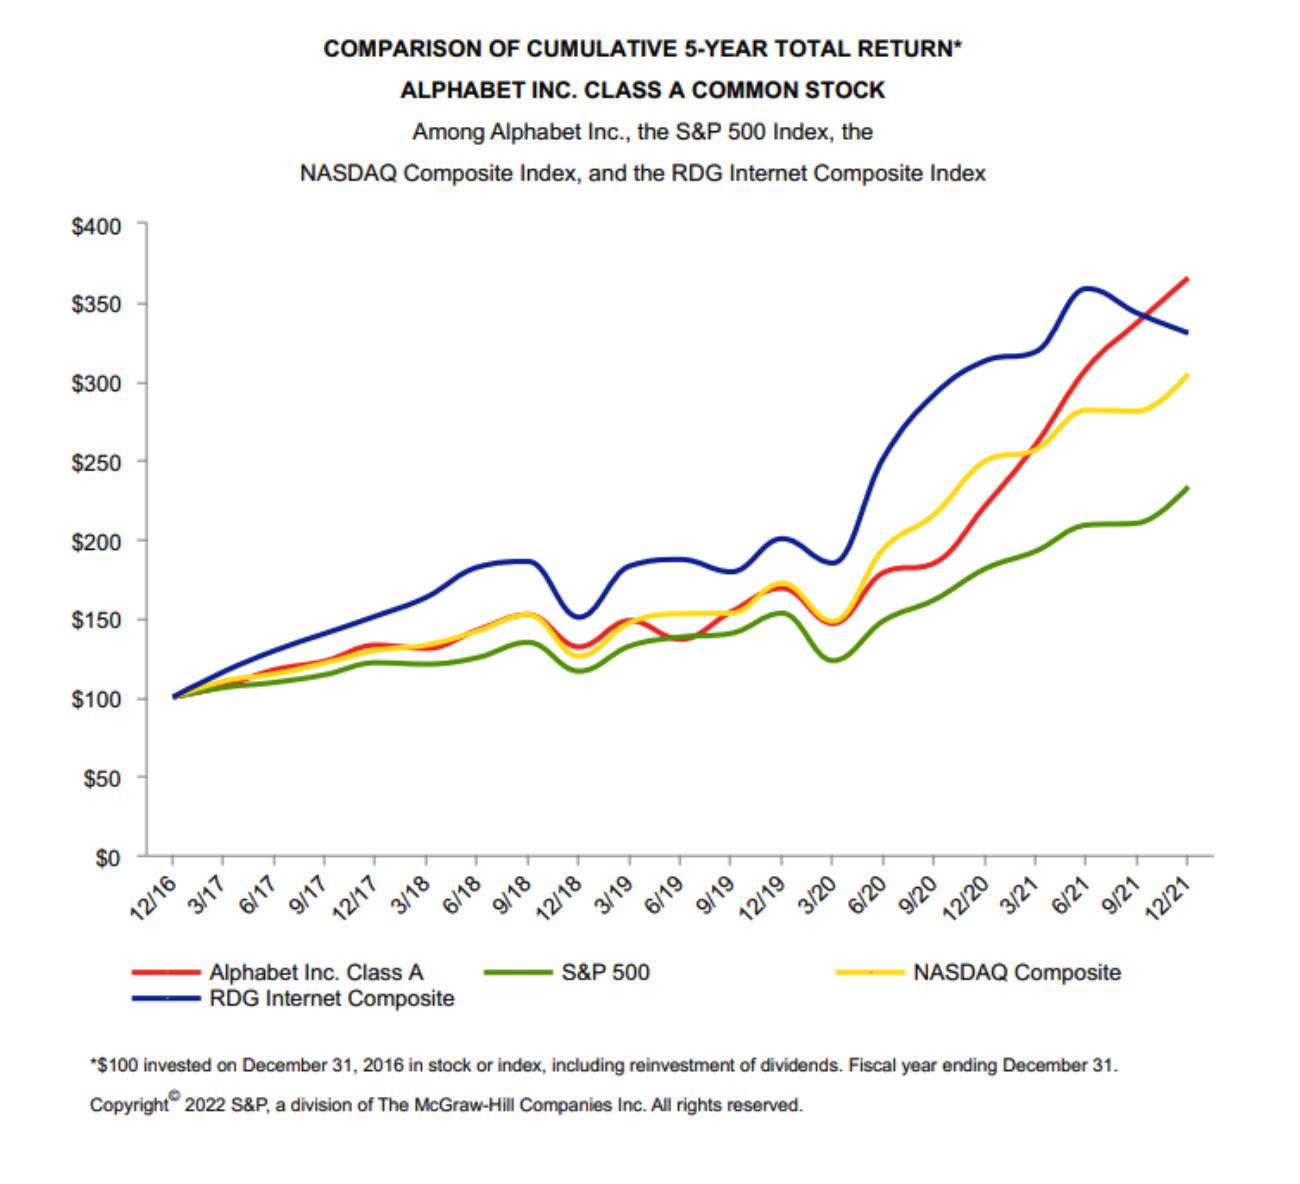

In [ ]:
plt_img_base64(docs[1])

## Create Chain with Retriever and Gemini LLM

In [ ]:
def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = [
        {
            "type": "text",
            "text": (
                "You are financial analyst tasking with providing investment advice.\n"
                "You will be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
                "Please use this information to provide investment advice related to the user's question. \n"
                f"User-provided question: {data_dict['question']}\n\n"
                "Text and / or tables:\n"
                f"{formatted_texts}"
            ),
        }
    ]

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            messages.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return [HumanMessage(content=messages)]


# Create RAG chain
chain_multimodal_rag = (
    {
        "context": retriever_multi_vector_img | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | ChatVertexAI(
        temperature=0, model_name="gemini-pro-vision", max_output_tokens=1024
    )  # Multi-modal LLM
    | StrOutputParser()
)

## Process user query

In [ ]:
query = "What are the critical difference between various graphs for Class A Share?"

In [ ]:
result = chain_multimodal_rag.invoke(query)

In [ ]:
Markdown(result)

 The graphs show the cumulative total return of Alphabet Inc. Class A common stock compared to the S&P 500, the Nasdaq Composite Index, and the RD Internet Composite Index over different time periods. The cumulative total return is the total return of an investment, including both capital appreciation and reinvested dividends, over a specified period.

The first graph shows the cumulative total return of Alphabet Inc. Class A common stock from December 2017 to December 2022. The stock outperformed the S&P 500, the Nasdaq Composite Index, and the RD Internet Composite Index over this period.

The second graph shows the cumulative total return of Alphabet Inc. Class A common stock from December 2016 to December 2021. The stock outperformed the S&P 500 and the Nasdaq Composite Index over this period but underperformed the RD Internet Composite Index.

The third graph shows the cumulative total return of Alphabet Inc. Class A common stock from December 2015 to December 2020. The stock outperformed the S&P 500, the Nasdaq Composite Index, and the RD Internet Composite Index over this period.

Overall, Alphabet Inc. Class A common stock has outperformed the S&P 500, the Nasdaq Composite Index, and the RD Internet Composite Index over the long term. However, the stock has underperformed the RD Internet Composite Index over the past year.

In [ ]:
query = "whats the number of employees google had as of dec 2021"

In [ ]:
chain_multimodal_rag.invoke(query)

' Based on the information provided, Alphabet Inc. had 156,500 employees as of December 31, 2021.'